C:\Users\Jcp45\AppData\Local\Temp\ipykernel_30156\4287996879.py:9: DtypeWarning: Columns (1,2,32,33,34,35,36,37,38,39,40,41,42,43) have mixed types. Specify dtype option on import or set low_memory=False.
  census_data = pd.read_csv('Census total.csv')
C:\Users\Jcp45\AppData\Local\Temp\ipykernel_30156\4287996879.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features.fillna(features.mean(), inplace=True)
C:\Users\Jcp45\AppData\Local\Temp\ipykernel_30156\4287996879.py:53: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  target.fillna(method='ffill', inplace=True)  # or another method as appropriate


Training MSE at different depths: [4.157174281069211, 1.3626275330053805, 0.022793332299972782, 9.070423079742553e-07, 3.100683947893664e-25]
Testing MSE at different depths: [4.1245489528422095, 1.3624758669560106, 0.022858401522632694, 9.321857356866412e-07, 3.086208218799043e-25]
Cross-validation MSE at different depths: [4.1572392788766415, 1.362432555836688, 0.022790200116076194, 9.204950770620618e-07, 1.4404398203084873e-25]


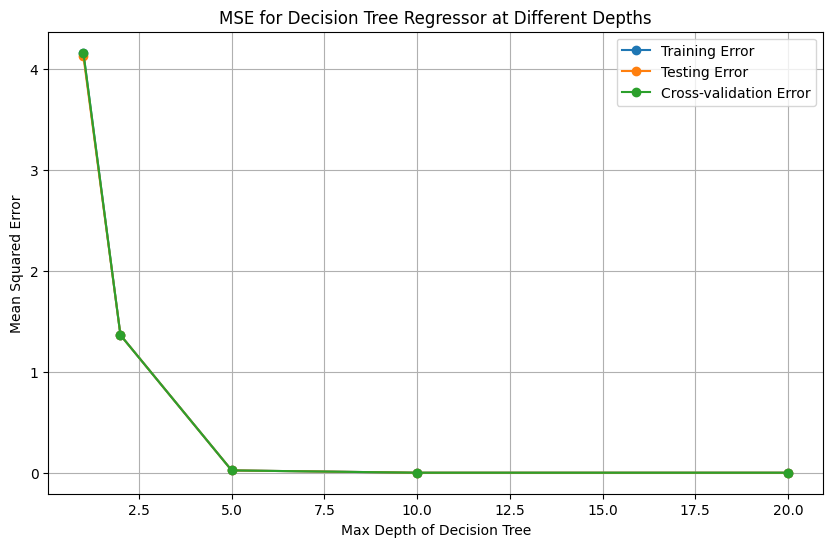

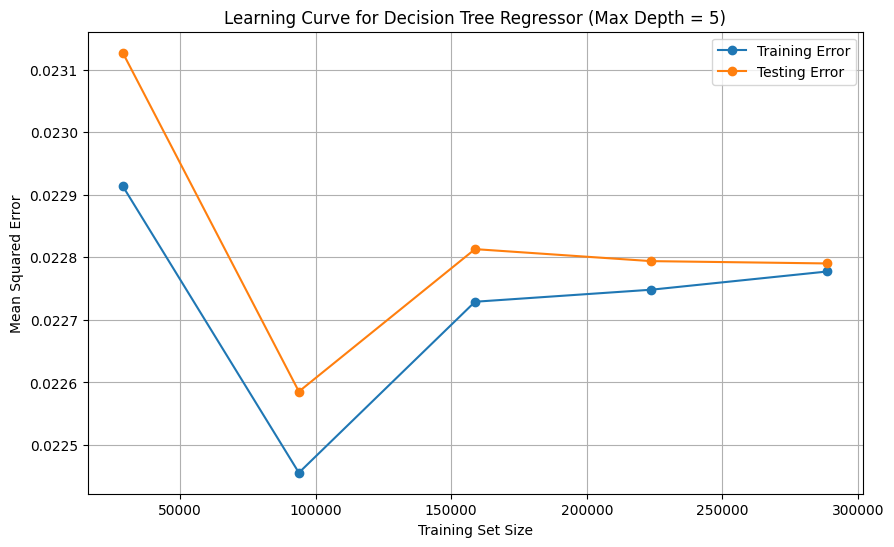

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, learning_curve, cross_val_score
from sklearn.metrics import mean_squared_error

# Load the datasets
census_data = pd.read_csv('Census total.csv')
district_data = pd.read_csv('updated_districts_cleaned.csv')

# Process 'Census Tract' column and ensure 'year' is an integer
census_data['Census Tract'] = census_data['Census Tract'].str.extract('(\d+\.?\d*)')[0].astype(str)
census_data['year'] = pd.to_numeric(census_data['year'], errors='coerce').astype('Int64')
district_data['Census Tract'] = district_data['Census Tract'].astype(str)

# Merge the data
combined_data = pd.merge(census_data, district_data, on='Census Tract', how='inner')

# Convert 'Median income (dollars)' to numeric and handle missing values
combined_data['Median income (dollars)'] = pd.to_numeric(combined_data['Median income (dollars)'], errors='coerce').fillna(0)

# Define and process all race columns
race_columns = ['White alone', 'Black or African American alone', 'Asian alone', 
                'American Indian and Alaska Native alone', 'Native Hawaiian and Other Pacific Islander alone', 
                'Some other race alone', 'Two or more races']
for col in race_columns:
    combined_data[col] = pd.to_numeric(combined_data[col], errors='coerce').fillna(0)

# Define age midpoints and calculate average age
age_midpoints = {
    'Under 5 years': 2.5, '5 to 9 years': 7.5, '10 to 14 years': 12.5, '15 to 19 years': 17.5, 
    '20 to 24 years': 22.5, '25 to 29 years': 27.5, '30 to 34 years': 32.5, '35 to 39 years': 37.5, 
    '40 to 44 years': 42.5, '45 to 49 years': 47.5, '50 to 54 years': 52.5, '55 to 59 years': 57.5, 
    '60 to 64 years': 62.5, '65 to 69 years': 67.5, '70 to 74 years': 72.5, '75 to 79 years': 77.5, 
    '80 to 84 years': 82.5
}

for age_group in age_midpoints:
    if age_group in combined_data.columns:
        combined_data[age_group] = pd.to_numeric(combined_data[age_group], errors='coerce').fillna(0)

combined_data['Total years'] = sum(combined_data[col] * age_midpoints[col] for col in age_midpoints if col in combined_data.columns)
combined_data['Total Population'] = combined_data[[col for col in age_midpoints if col in combined_data.columns]].sum(axis=1)
combined_data['Average Age'] = combined_data['Total years'] / combined_data['Total Population']

# Select features and target variable
features = combined_data[['Median income (dollars)', 'Average Age'] + race_columns]  
target = combined_data['Average Age']

# Handling missing values if necessary
features.fillna(features.mean(), inplace=True)
target.fillna(method='ffill', inplace=True)  # or another method as appropriate

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Initialize Decision Tree models with different depths
max_depths = [1, 2, 5, 10, 20]
train_errors = []
test_errors = []
cross_val_mse = []

for depth in max_depths:
    # Create a Decision Tree regression model
    dt_model = DecisionTreeRegressor(max_depth=depth, random_state=42)
    
    # Train the model on the training data
    dt_model.fit(X_train, y_train)
    
    # Predict on both training and testing datasets
    y_train_pred = dt_model.predict(X_train)
    y_test_pred = dt_model.predict(X_test)
    
    # Calculate Mean Squared Errors for training and testing datasets
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    
    train_errors.append(train_mse)
    test_errors.append(test_mse)
    
    # Perform cross-validation
    scores = cross_val_score(dt_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    # Calculate mean of cross-validation MSE and convert to positive
    cross_val_mse.append(-scores.mean())

# Print MSE values for different depths
print("Training MSE at different depths:", train_errors)
print("Testing MSE at different depths:", test_errors)
print("Cross-validation MSE at different depths:", cross_val_mse)

# Plot the MSE values for different depths
plt.figure(figsize=(10, 6))
plt.plot(max_depths, train_errors, label='Training Error', marker='o')
plt.plot(max_depths, test_errors, label='Testing Error', marker='o')
plt.plot(max_depths, cross_val_mse, label='Cross-validation Error', marker='o')
plt.xlabel('Max Depth of Decision Tree')
plt.ylabel('Mean Squared Error')
plt.title('MSE for Decision Tree Regressor at Different Depths')
plt.legend()
plt.grid(True)
plt.show()

# Learning Curve for max depth = 5
train_sizes, train_scores, test_scores = learning_curve(
    DecisionTreeRegressor(max_depth=5, random_state=42), X_train, y_train, cv=5, scoring='neg_mean_squared_error'
)

train_scores_mean = -np.mean(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)

# Plot the learning curve for max depth = 5
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training Error', marker='o')
plt.plot(train_sizes, test_scores_mean, label='Testing Error', marker='o')
plt.xlabel('Training Set Size')
plt.ylabel('Mean Squared Error')
plt.title('Learning Curve for Decision Tree Regressor (Max Depth = 5)')
plt.legend()
plt.grid(True)
plt.show()
